In [11]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
# warnings.filterwarnings('ignore')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [12]:
from dtreeviz.trees import *

In [13]:
df = pd.read_csv('credit_risk_dataset.csv')
display(df)


,person_age,person_income,person_home_ownership,person_emp_length,...,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,...,1,0.59,Y,3
1,21,9600,OWN,5.0,...,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,...,1,0.57,N,3
3,23,65500,RENT,4.0,...,1,0.53,N,2
4,24,54400,RENT,8.0,...,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,...,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,...,0,0.15,N,19
32578,65,76000,RENT,3.0,...,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,...,0,0.10,N,26


In [14]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [15]:
dep_var = 'loan_status'

In [16]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
cont

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [17]:
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1})
df['loan_grade'] = df['loan_grade'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [19]:
procs = [Categorify, FillMissing] # Normalize

splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train),len(to.valid)

(26065, 6516)

In [20]:
to.classes['loan_grade']

['#na#', 1, 2, 3, 4, 5, 6, 7]

In [ ]:
#hide_output
to.show(3)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file,person_emp_length_na,loan_int_rate_na,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
20086,RENT,DEBTCONSOLIDATION,2,0,False,False,28,19200,0.0,4000,12.69,0.21,8,1
24151,RENT,VENTURE,1,0,False,True,30,42000,4.0,10000,10.99,0.24,9,0
15192,MORTGAGE,PERSONAL,2,0,False,False,25,125000,9.0,12000,11.11,0.10,3,0


In [21]:
save_pickle('to.pkl',to)

In [22]:
#hide
to = load_pickle('to.pkl')

In [23]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [24]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y);

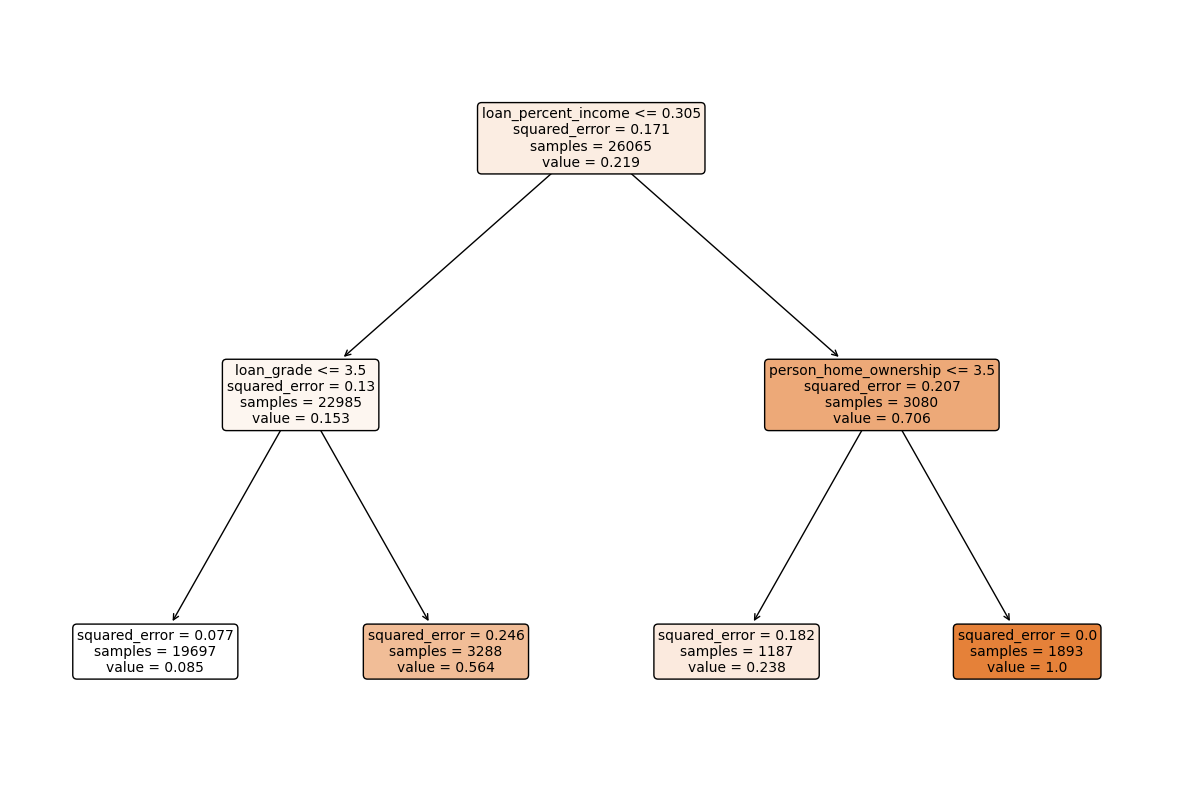

In [25]:
# draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

plt.figure(figsize=(15, 10))
plot_tree(m, filled=True, feature_names=xs.columns, rounded=True, fontsize=10)
plt.show()

In [35]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

NameError: name 'dtreeviz' is not defined

In [36]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [37]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
m_rmse(m, xs, y)

0.0

In [39]:
m_rmse(m, valid_xs, valid_y)

0.339718

In [40]:
m.get_n_leaves(), len(xs)

(2263, 26065)

In [41]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.229001, 0.254863)

In [51]:
def rf(xs, y, n_estimators=40, max_samples=20_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [52]:
m = rf(xs, y);

In [53]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.196295, 0.242385)

In [54]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-package

In [55]:
r_mse(preds.mean(0), valid_y)

0.242385

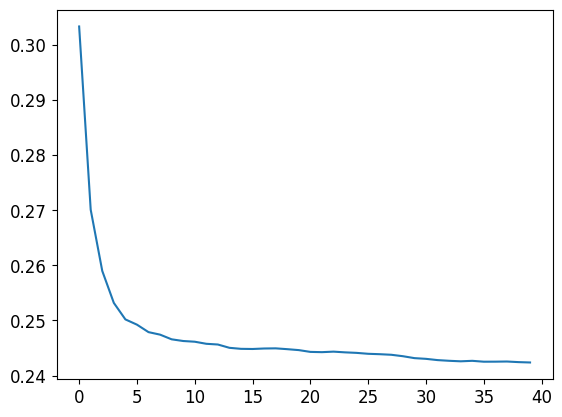

In [56]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [57]:
r_mse(m.oob_prediction_, y)

0.244499

In [58]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-package

In [59]:
preds.shape

(40, 6516)

In [60]:
preds_std = preds.std(0)

In [61]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [62]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
11,loan_percent_income,0.264846
0,person_home_ownership,0.144942
2,loan_grade,0.134748
7,person_income,0.128930
10,loan_int_rate,0.103665
1,loan_intent,0.089535
8,person_emp_length,0.049466
9,loan_amnt,0.039635
6,person_age,0.020461
12,cb_person_cred_hist_length,0.015736


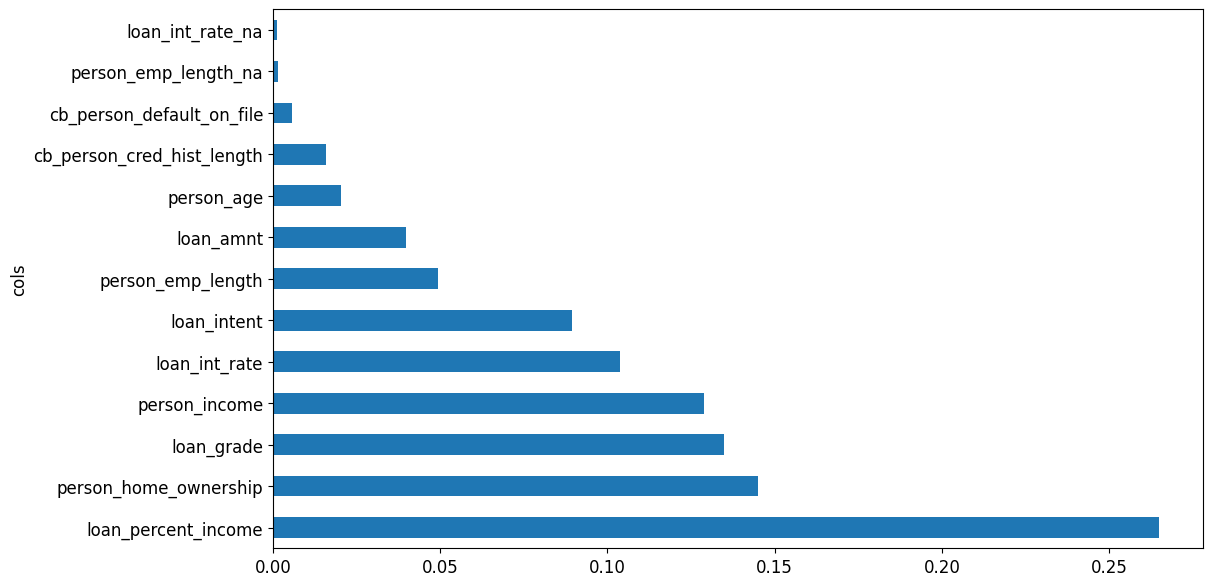

In [63]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [64]:
print('Hello')

Hello
